In [1]:
import pandas as pd
import quandl as qd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import os

In [2]:
key = os.environ.get('Quandl_API_Key')
qd.ApiConfig.api_key = key

In [3]:
# "RATEINF/INFLATION_USA" "MULTPL/SP500_PE_RATIO_MONTH" "MULTPL/SP500_EARNINGS_MONTH"

In [4]:
start_date = "1963-01-01"

end_date = "2023-01-31"

inflation_data = qd.get("RATEINF/INFLATION_USA", start_date = start_date, end_date = end_date)

pe_data = qd.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = start_date, end_date = end_date)

In [5]:
df = pd.merge_asof(left=inflation_data, right=pe_data, right_index=True,left_index=True,direction='nearest')
df = df.rename(columns={'Value_x':'Inflation',
                        'Value_y':'S&P500_PE'})
df

,Inflation,S&P500_PE
Date,,
1963-01-31,1.333,17.83
1963-02-28,0.997,17.70
1963-03-31,1.329,18.32
1963-04-30,0.993,18.47
1963-05-31,0.993,18.26
...,...,...
2022-08-31,8.263,19.98
2022-09-30,8.202,18.12
2022-10-31,7.745,20.14


In [6]:
df.describe()

,Inflation,S&P500_PE
count,720.000000,720.000000
mean,3.893001,19.619361
std,2.861944,11.844516
min,-2.097000,6.790000
25%,1.977000,14.297500
50%,3.087500,18.040000
75%,4.869250,22.432500
max,14.756000,123.730000


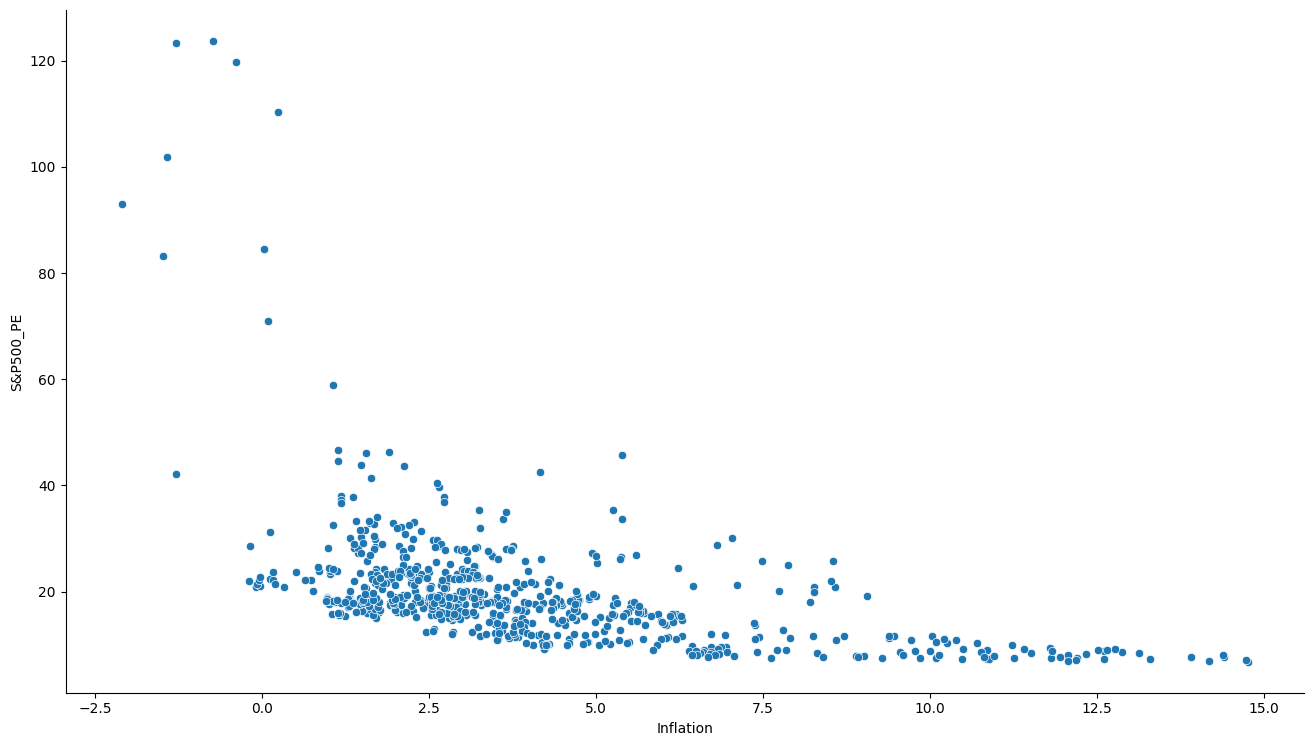

In [7]:
g = sns.relplot(x='Inflation', y='S&P500_PE', data=df)
g.fig.set_size_inches(15,8)

In [8]:
#Remove outliers in S&P 500

upper_limit = df['S&P500_PE'].mean()+2*df['S&P500_PE'].std()
lower_limit = df['S&P500_PE'].mean()-2*df['S&P500_PE'].std()

df = df[(df['S&P500_PE'] < upper_limit) & (df['S&P500_PE'] > lower_limit)]

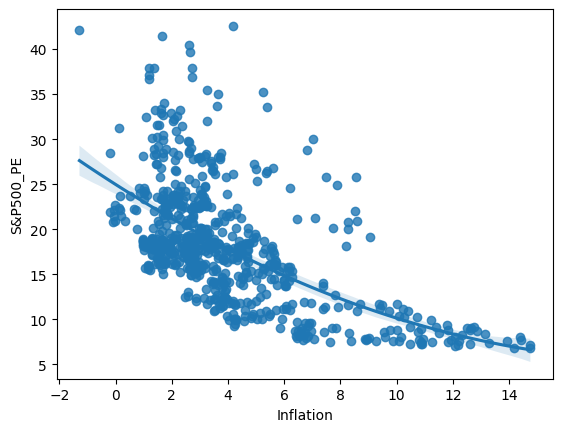

In [9]:
sns.regplot(x='Inflation', y='S&P500_PE', data=df, order = 2);

In [10]:
X = df['Inflation']
y = df['S&P500_PE']

## Statsmodel Method

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [11]:
from sklearn.preprocessing import PolynomialFeatures
sm_poly = PolynomialFeatures(degree=2)
sm_poly_features = sm_poly.fit_transform(X.values.reshape(-1,1))

model = sm.OLS(y, sm_poly_features).fit()
ypred = model.predict(sm_poly_features) 

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S&P500_PE   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     192.0
Date:                Thu, 02 Feb 2023   Prob (F-statistic):           3.45e-67
Time:                        17:42:05   Log-Likelihood:                -2169.1
No. Observations:                 703   AIC:                             4344.
Df Residuals:                     700   BIC:                             4358.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.9699      0.570     43.831      0.000      23.851      26.088
x1            -1.9902      0.234     -8.502      0.000      -2.450      -1.531
x2             0.0506      0.018      2.778      0.006       0.015       0.086
==============================================================================
Omnibus:                      158.987   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              308.115
Skew:                           1.292   Prob(JB):                     1.24e-67
Kurtosis:                       4.960   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
model.params

const    24.969945
x1       -1.990223
x2        0.050557
dtype: float64

In [23]:
model.conf_int()

,0,1
const,23.851433,26.088457
x1,-2.449803,-1.530644
x2,0.014823,0.086291


In [14]:
model.conf_int()[0][0]

23.851433226060117

In [24]:
user_pred = 3

print(f"""The estimated PE value for the S&P 500 based on an inflation rate of {user_pred} is {round(model.params[0] + model.params[1]*user_pred + model.params[2]*user_pred,2)}""")

The estimated PE value for the S&P 500 based on an inflation rate of 3 is 19.15


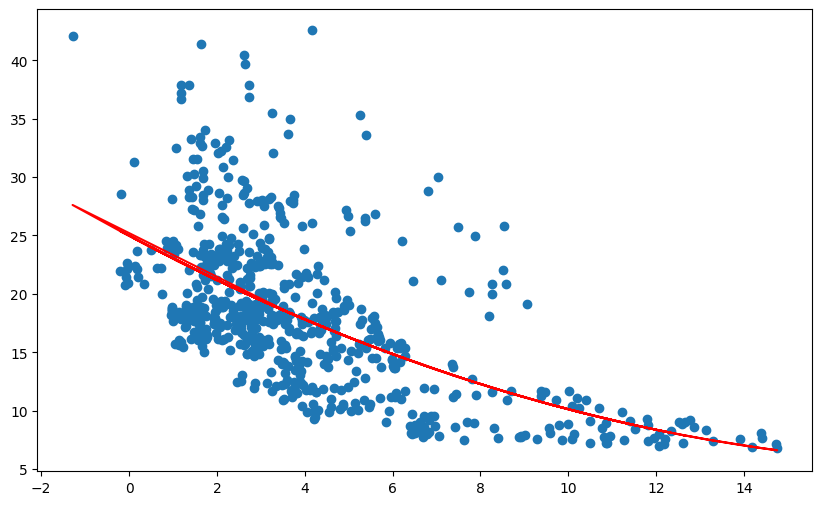

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y)
plt.plot(X, ypred, c="red")
plt.show()